In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn.linear_model as lm
import numpy as np
np.random.seed(888)
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Reshape,Dropout,LSTM,Activation
from keras.layers.advanced_activations import LeakyReLU,PReLU

from keras.regularizers import l1,l2
from keras.constraints import nonneg

%matplotlib inline
import tensorflow
import keras
import math
import time
import datetime
from sklearn import cluster, datasets, metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing 

Using TensorFlow backend.


In [3]:
oli = pd.read_csv('cleanoutwvd.csv')
olier = oli.copy();
#去掉當量暫時不用

# olier.speed=(olier.speed);olier
# olier.YY=olier.YY-16;
olier=olier.drop(['YY','day','date','time','direct','lane','eqflow','fakeornot','realvd'],axis=1);olier
# olier['serial'] = olier.index

# mean zero 標準化
olier = preprocessing.scale(olier)

# normalize the dataset
# scaler = MinMaxScaler(feature_range=(-1, 1))
# olier = scaler.fit_transform(olier)
olierc=pd.DataFrame(olier,columns=['sortby','speed','accu'])

# move speed to the end

olierclo = olierc.columns.tolist()
olierc=olierc[olierclo[:-2]+olierclo[-1:]+olierclo[-2:-1]]
# olier= olier[olierclo[-1:]+olierclo[:1]+olierclo[2:3]+olierclo[1:2]]; # 有serial時的speed

#0225version
def cleanout(inp,i):
    dfvdi= inp.where(inp['sortby']==i).dropna();

    outp = dfvdi.copy()
    # 某個時間要把fakeornot去掉 
    outpp = outp.values.astype('float32')
    # 分出train 跟test
    train_size = int(len(outpp) * 0.75)
    test_size = len(outpp) - train_size
    train, test = outpp[0:train_size,:], outpp[train_size:len(outpp),:]
    if (len(train)%168 != 0) or (len(test)%168 != 0) :
        train=train[:-(len(train)%168)]
        test=test[:-(len(test)%168)]
        
    return train,test


import time
start = time.time()

sortbylist=olierc['sortby'].unique().tolist()

sortbylist2=[sortbylist[3],sortbylist[4],sortbylist[6],sortbylist[8],sortbylist[29],sortbylist[38]]


tralist = []
teslist = []

for i in sortbylist2:
    temptra,temptes=cleanout(olierc,i)
    #train
    for ele in temptra.tolist():
        tralist.append(ele)
    #test
    for ele3 in temptes.tolist():
        teslist.append(ele3)

cluster01tra=np.array(tralist)
print len(cluster01tra)
cluster01tes=np.array(teslist)
print len(cluster01tes)

# scaler = MinMaxScaler(feature_range=(-1, 1))
# cluster01tra = scaler.fit_transform(cluster01tra)
# cluster01tes = scaler.fit_transform(cluster01tes)

# cluster01tra = preprocessing.scale(cluster01tra)
# cluster01tes = preprocessing.scale(cluster01tes)



print(start - time.time()),'seconds'



30240
10080
-0.190485954285 seconds


In [4]:
import time
start = time.time()
#起始隨機子
np.random.seed(888)
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(0,len(dataset)-look_back-1,look_back):
        a = dataset[i:(i+look_back), 0:nort]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i+look_back+look_back, nort-1])
#     return dataX,dataY
    return np.array(dataX), np.array(dataY)

# 看資料有幾個欄位就寫幾
nort = 3
# magic number
look_back = 168
# cut off remainder
train = cluster01tra
test = cluster01tes
# check data lenth when cut off remainder
print(len(train), len(test))

# seperate data to input"X" and output"Y"
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 3))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 3))

# create and fit Multilayer Perceptron model
model = Sequential()
# model = Model(input=look_back*nort,output=[look_back,2])


model.add(LSTM(168, input_shape=(look_back,nort), return_sequences=True))
model.add(Activation("linear"))
model.add(Dropout(0.35))
model.add(LSTM(168, input_shape=(look_back,nort)))
model.add(Activation("linear"))
model.add(Dropout(0.35))
model.add(Dense(look_back,W_constraint=nonneg()))
model.add(Activation("linear")) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=50, batch_size=256, verbose=0)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

print(start - time.time()),'seconds'

# pre = testPredict.reshape(len(testPredict)*len(testPredict[0]),)
# ori = testY.reshape(len(testY)*len(testY[0]),)
# pd.DataFrame(pre).to_csv('pre.csv')
# pd.DataFrame(ori).to_csv('ori.csv')

(30240, 10080)
Train Score: 0.22 RMSE
Test Score: 0.65 RMSE
-264.356730938 seconds


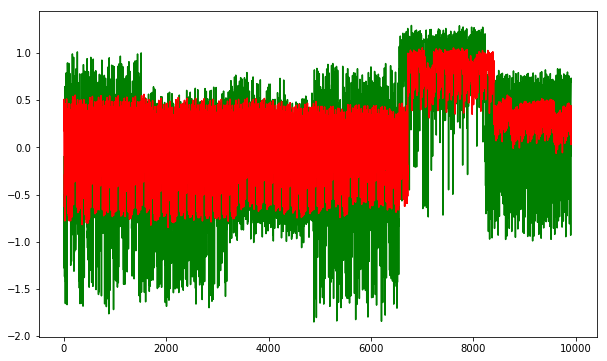

In [5]:



# pre = trainPredict.reshape(len(trainPredict)*len(trainPredict[0]),)
# ori = trainY.reshape(len(trainY)*len(trainY[0]),)



pre = testPredict.reshape(len(testPredict)*len(testPredict[0]),)
ori = testY.reshape(len(testY)*len(testY[0]),)
plt.figure(figsize=(10,6))
# plt.plot(pre[600:800],color='r')
# plt.plot(ori[600:800],color='g')

plt.plot(pre,color='r')
plt.plot(ori,color='g')
plt.plot(pre,color='r')

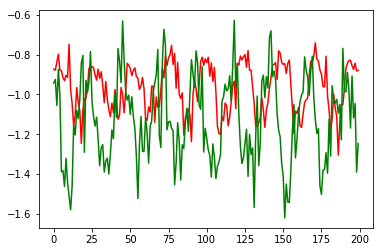

In [9]:
plt.plot(pre[600:800],color='r')
plt.plot(ori[600:800],color='g')